# Pitch & Roll prediction model

In [2]:
import gc
import os
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [3]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.0


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 4
Platform: windows
number of workers: 0


# Constants

In [5]:
# change to appropriate location
TRAIN_FOLDER = "../3dmodel/test_4_episode_"
MODEL_NAME = "LSTM_PR_single_output_roll"
MODEL_STATE_FOLDER = f"model_states/{MODEL_NAME}"
RESULT_FOLDER = f"../results/{MODEL_NAME}"
TRAIN_RESULT_FOLDER = f"training_results/{MODEL_NAME}"

In [6]:
if not os.path.exists(MODEL_STATE_FOLDER):
    os.mkdir(MODEL_STATE_FOLDER)
if not os.path.exists(TRAIN_RESULT_FOLDER):
    os.mkdir(TRAIN_RESULT_FOLDER)
if not os.path.exists(RESULT_FOLDER):
    os.mkdir(RESULT_FOLDER)

In [7]:
FRAMES_IN = 10
FRAMES_OUT = 1

N_EPISODES = 540
FRAMES_PER_EPISODE = 400

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

CUDA = device.type == 'cuda'
DEVICE = device

# Load data from episodes

In [8]:
# view first episode 
filename = "../3dmodel/test_4_episode_1/labels_0.json"
data = []
labels = json.load(open(filename))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468
...,...,...
395,-0.204481,1.503337
396,1.074743,10.724272
397,13.373594,1.542949
398,11.193637,-0.848632


In [9]:
# load all data
episodes = [] # holds pitch, roll, episode number and position within episode number
pr_per_episode = [] # holds all pitch and roll tuples per episode in one row (see pr_per_episode_df)
for ep in range(1, N_EPISODES+1):
    filename = TRAIN_FOLDER+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    pr_in_current_episode = []
    for i in labels:
        pr_in_current_episode.append(labels[i])
        episodes.append(labels[i]+[ep, i])
    pr_per_episode.append(pr_in_current_episode)

In [10]:
p_r_df = pd.DataFrame(episodes)
# p_r_df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
p_r_df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df = p_r_df.drop([2,3], axis=1)     # drop episode and position_within_episode
p_r_df.head()

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [11]:
pr_per_episode_df = pd.DataFrame(pr_per_episode)
pr_per_episode_df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,"[15.9158690209565, 2.3584162956378014]","[14.29592488097425, 1.7003911752437184]","[6.2135895738216185, 1.6113252950233405]","[1.235337361757596, 6.175460896553669]","[1.341678284492817, 3.695467874019875]","[-0.0651516203579112, 3.0756651325514186]","[-4.392773839217525, 0.8726621608752939]","[-4.184235784139164, 0.35570707390756684]","[-3.3195511241318867, 6.666652243167843]","[5.894038319728926, -0.13849362470644613]",...,"[10.389031062517569, 1.5248242575580084]","[-1.2002740520448067, 0.5092731518638726]","[-10.535511299457662, -4.131095631735996]","[-18.896939235154417, -4.945806145463817]","[-22.184256348715486, -1.9589200251876364]","[-0.2044812962373426, 1.503336589150854]","[1.0747428590627885, 10.724272114907427]","[13.3735940647023, 1.5429493384594009]","[11.19363673825518, -0.8486316877453378]","[5.131548017300437, 0.9777773314587621]"
1,"[15.97866748773289, 2.268047343389832]","[9.855846859112509, 1.360887657924949]","[6.105283691039549, 1.5623034265245723]","[1.3507750292502163, 4.69679068181667]","[1.724415511875592, 4.076017413155836]","[0.03351754252109094, 3.1310278711991915]","[-7.604052164296134, 1.8397739918625224]","[-2.5471177738191515, 2.5391520656996245]","[-2.625542432756061, 7.979014181804202]","[6.084213411223707, 0.050736486104279443]",...,"[9.820045568804241, 1.8697905388306129]","[1.4623980360913844, 0.5153293418627053]","[-10.619933291372666, -3.1525508644909594]","[-15.18629041193054, -5.8295536500011895]","[-21.331025702502906, -4.46392562734884]","[-0.980658924236567, 0.000323666141662183]","[1.1033292284517018, 11.141469460921915]","[14.080388870204388, 0.990625450896085]","[11.345563197284712, -0.7964093420118897]","[4.760598735929752, 1.6810054975536355]"
2,"[15.961578354429518, 2.074803789410423]","[6.179635849683839, 0.12110205542910284]","[6.079602606647125, 1.6753055979695541]","[1.3610495547526196, 8.341244726699365]","[0.2675885889498374, 4.800268474629186]","[0.06658679384694029, 3.1533924718627517]","[-5.6663031642145985, 1.2498673085563288]","[-6.884764942802091, 0.6056172923359865]","[-2.0016676178818074, 6.428251747264541]","[6.3722296819184505, 0.18303076698380022]",...,"[9.64882211782213, 1.973062358750971]","[2.395990446922511, 0.4464584900686305]","[-10.690737593629956, -2.750964556154771]","[-14.010888280304924, -6.054184484537745]","[-21.49614211059338, -4.60819715186608]","[-4.0433481914688425, 1.2884030224101293]","[1.1818524982447534, 11.202268389818784]","[14.342162700334297, 0.7591126138013591]","[8.761085355922647, -0.30987522391631195]","[4.628031167442151, 1.9668671637303579]"
3,"[7.69906521829289, 1.5796155014713218]","[8.481780991514256, 0.05603940762328032]","[3.159275826059072, 0.8631695853111513]","[1.049441063612711, 2.2469629763088257]","[0.3593771266476851, 1.8488201505313813]","[-0.07217797069325685, 1.49066178576372]","[-2.60443416001296, 0.27787303957087833]","[-5.056486372756112, 0.3636566403690948]","[-1.834612289840697, 3.3018218740372376]","[2.911777518181313, -0.18950627990486155]",...,"[5.454093028683711, 0.6530340130189489]","[-1.6791362668768735, 0.18489125982090143]","[-5.466481284290821, -2.2171972253493215]","[-11.403407215591903, -1.6377460675585367]","[-9.300110224841715, 0.5591612804484688]","[-0.9304575674455022, 1.7758436346746147]","[0.5600581696638561, 4.948483152731639]","[6.361704787294284, 1.072871920838734]","[6.398844794679874, -0.44728280852408636]","[2.689249101248651, 0.22945817745416852]"
4,"[7.810402424405974, 1.4887826299683204]","[7.868472692729423, 0.18104613012244872]","[3.1332145989506532, 0.9057401800562839]","[0.9454851575582939, 2.1807891154219803]","[0.49654637500602317, 1.7821752200352163]","[-0.04738833270922448, 1.498974979757272]","[-2.617495189253317, 0.3204662326372101]","[-4.8539576034868945, 0.6764536111050119]","[-1.7194979891165945, 3.217247483526378]","[2.9227715614240943, -0.18400777751980293]",...,"[5.2915481868157475, 0.7305929454785594

In [12]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to normalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [13]:
# normalize PR-values
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
p_r_df.head()

,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


# Create input and output sequences

In [14]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, 
        input_feature_columns, 
        output_feature_columns,
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT, 
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):
        for l in range(episode_length-output_sequence_length-input_sequence_length+1):

            i = l+(n*episode_length)

            # sequence = input_data.iloc[i:i+input_sequence_length][input_feature_columns]
            sequence = input_data.iloc[i:i+input_sequence_length]

            target_position = i + input_sequence_length
            # target = input_data.iloc[target_position:target_position+output_sequence_length][output_feature_columns]
            target = input_data.iloc[target_position:target_position+output_sequence_length][output_feature_columns]
            
            sequences.append((sequence, target))

    return sequences

In [15]:
input_features = ["pitch", "roll"]
output_features = ["roll"]
all_sequences = create_sequences(p_r_df, input_features, output_features)

  0%|          | 0/540 [00:00<?, ?it/s]

In [16]:
len(all_sequences), all_sequences[0][0].shape, all_sequences[0][1].shape 

(210600, (10, 2), (1, 1))

In [17]:
all_sequences[0][0]

,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061
5,-0.000724,0.034174
6,-0.048809,0.009696
7,-0.046492,0.003952
8,-0.036884,0.074074
9,0.065489,-0.001539


In [18]:
all_sequences[0][1]

,roll
10,0.05608


In [19]:
index = 349
print("Sequence for target value: ", all_sequences[index][1])
pd.concat([all_sequences[index][0].head(2),all_sequences[index][0].tail(2)])

Sequence for target value:           roll
359 -0.108568


,pitch,roll
349,-0.027831,0.082243
350,0.110468,0.039379
357,-0.054622,-0.087071
358,0.143515,-0.115367


In [20]:
index = 350
print("Sequence for target value: ", all_sequences[index][1])
pd.concat([all_sequences[index][0].head(2),all_sequences[index][0].tail(2)])

Sequence for target value:           roll
360 -0.057671


,pitch,roll
350,0.110468,0.039379
351,0.156376,-0.051486
358,0.143515,-0.115367
359,0.247955,-0.108568


In [21]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print(len(train_indices), len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
168480 42120
[167621, 29184, 6556, 194393, 72097, 64196, 58513, 36579, 193061, 26868]
[131073, 3, 4, 131078, 7, 8, 131083, 131088, 131089, 131090]


In [22]:
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/168480 [00:00<?, ?it/s]

  0%|          | 0/42120 [00:00<?, ?it/s]

True
168480 (10, 2) (1, 1)
42120 (10, 2) (1, 1)


## Pytorch Dataset and DataLoader

In [23]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        input, output = self.sequences[index]

        return dict(
            input = torch.Tensor(input.to_numpy()),
            output = torch.Tensor(output.to_numpy().squeeze()),
        )

In [24]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = 8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [25]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [26]:
data_module_train_dataloader = data_module.train_dataloader()
data_module_train_dataloader.dataset.__getitem__(0)["output"]

tensor(-0.0671)

In [27]:
for item in data_module_train_dataloader:
    x_input = item["input"]
    x_output = item["output"]
    print(x_input.shape)
    print(x_output.shape)
    break

torch.Size([64, 10, 2])
torch.Size([64])


In [28]:
# turn sequence list into Dataset object
train_dataset = PRDataset(train_sequences)

In [29]:
for item in train_dataset:
    print(item["input"].shape)
    print(item["output"].shape)
    print(item["output"])
    break

torch.Size([10, 2])
torch.Size([])
tensor(-0.0671)


## LSTM Model

In [30]:
class RollPredictor(nn.Module):
    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.2
        )

        self.fc = nn.Linear(n_hidden, 1)

    def forward(self, x):
        # print(f"input size: {x.shape}")
        self.lstm.flatten_parameters()
        # print(f"flatten size: {x.shape}")
        _, (hidden, _) = self.lstm(x)
        # print(f"hidden size: {hidden.shape}")
        # grab hidden vector from last LSTM layer (hidden size = (1*num_layers, batch size, hidden size))
        out = hidden[-1]
        # print(f"out size: {out.shape}")
        return self.fc(out)

In [31]:
test = RollPredictor(2)
y = test(x_input)
y.squeeze(1).shape == x_output.shape

True

# Training

In [32]:
# get the first batch out of the dataloader for testing purposes
for batch in data_module.train_dataloader():
    x_train = batch["input"]
    y_train = batch["output"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 10, 2]) torch.Size([64])


In [33]:
model = RollPredictor(n_features=2)

outputs = model.forward(x_train)
# output should be a sequence of pitch and roll (2 features)
outputs.shape

torch.Size([64, 1])

### Training loop

In [34]:
model = RollPredictor(n_features=2)

if CUDA:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# TRACKERS
train_losses_epoch = []
val_losses_epoch = []

n_epochs = NUM_EPOCHS

for epoch in tqdm(range(n_epochs)):

    # validation loss
    with torch.no_grad():
        i = 0
        total_batch_loss = 0
        for batch in data_module.val_dataloader():
            x_val = batch["input"]
            y_val = batch["output"]
            i += 1

            if CUDA: 
                x_val = batch["input"].cuda()
                y_val = batch["output"].cuda()
            
            # Predict on forward pass 
            y_pred = model.forward(x_val)

            loss = criterion(y_pred.squeeze(1), y_val)
            total_batch_loss += loss.item()

        mean_val_loss = total_batch_loss/i
        val_losses_epoch.append(mean_val_loss)
        val_loss = round(mean_val_loss, 6)


    losses_current_batch = []
    i = 0
    total_batch_loss = 0

    for batch in data_module.train_dataloader():
        print(f"batch {i}", end='\r')
        i += 1
        x_train = batch["input"]
        y_train = batch["output"]

        if CUDA: 
            x_train = batch["input"].cuda()
            y_train = batch["output"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)

        # Calculate loss/error
        loss = criterion(y_pred.squeeze(1), y_train)
        losses_current_batch.append(loss.item())
        total_batch_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    mean_train_loss = total_batch_loss/i
    train_losses_epoch.append(mean_train_loss)
    train_loss = round(mean_train_loss, 6)

    print(f"EPOCH {epoch} training loss: {train_loss} | validation loss: {val_loss}")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0 training loss: 0.001933 | validation loss: 0.006295
EPOCH 1 training loss: 0.00176 | validation loss: 0.001718
EPOCH 2 training loss: 0.001736 | validation loss: 0.001717
EPOCH 3 training loss: 0.001715 | validation loss: 0.001697
EPOCH 4 training loss: 0.001701 | validation loss: 0.001685
EPOCH 5 training loss: 0.001685 | validation loss: 0.00167
EPOCH 6 training loss: 0.001673 | validation loss: 0.001664
EPOCH 7 training loss: 0.001661 | validation loss: 0.001652
EPOCH 8 training loss: 0.001654 | validation loss: 0.001644
EPOCH 9 training loss: 0.001648 | validation loss: 0.001642
EPOCH 10 training loss: 0.001636 | validation loss: 0.001632
EPOCH 11 training loss: 0.001629 | validation loss: 0.001621
EPOCH 12 training loss: 0.001618 | validation loss: 0.001617
EPOCH 13 training loss: 0.001605 | validation loss: 0.001612
EPOCH 14 training loss: 0.001594 | validation loss: 0.001602
EPOCH 15 training loss: 0.001577 | validation loss: 0.001588
EPOCH 16 training loss: 0.001565 | v

### Save and load model

In [35]:
# save train losses per epoch
filename = f'{TRAIN_RESULT_FOLDER}/train_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
with open(filename, 'wb') as f: 
    pickle.dump(train_losses_epoch, f)
# save val losses per epoch
filename = f'{TRAIN_RESULT_FOLDER}/val_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
with open(filename, 'wb') as f: 
    pickle.dump(val_losses_epoch, f)

In [36]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
torch.save(model.state_dict(), filename)

In [34]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = RollPredictor(n_features=2)
loaded_model.load_state_dict(torch.load(filename))
if CUDA: 
    loaded_model = loaded_model.cuda()

loaded_model.eval()

RollPredictor(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## Training results

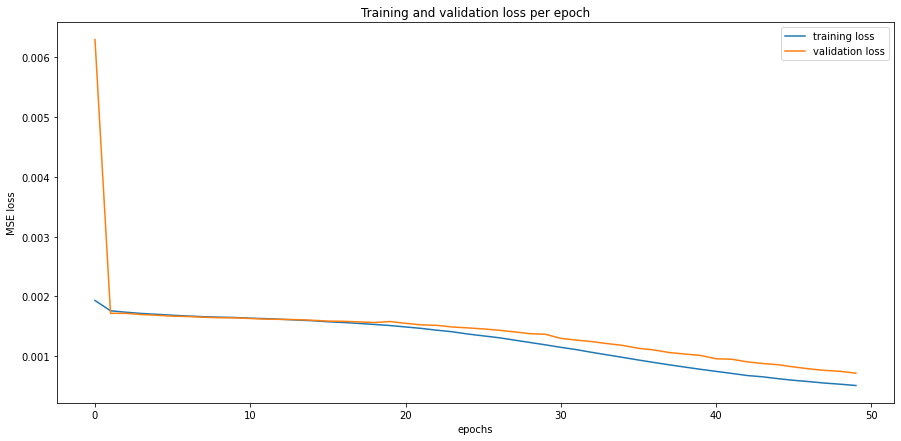

In [38]:
plt.figure(figsize=(15, 7))
plt.plot(range(NUM_EPOCHS), train_losses_epoch, label='training loss')
plt.plot(range(NUM_EPOCHS), val_losses_epoch, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("Training and validation loss per epoch")
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/train-test-loss_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

# Testing

In [35]:
predictions = []
labels = []
loss_values = []

for item in tqdm(data_module.test_dataloader()):
    x_test = item["input"]
    y_test = item["output"]

    if CUDA:
        x_test = x_test.cuda()
        y_test = y_test.cuda()

    output = loaded_model(x_test)
    predictions.append(output.item())
    labels.append(y_test.item())

  0%|          | 0/42120 [00:00<?, ?it/s]

In [39]:
len(predictions), len(test_sequences)

(42120, 42120)

In [40]:
predictions[0], labels[0]

(0.004330962896347046, 0.0031125687528401613)

In [41]:
denorm_pr(predictions[2]), denorm_pr(labels[2])

(-2.666085585951805, -1.7782276310026646)

In [42]:
denorm_predictions = []
denorm_labels = []

for el in predictions:
    denorm_predictions.append(denorm_pr(el))

for el in labels:
    denorm_labels.append(denorm_pr(el))

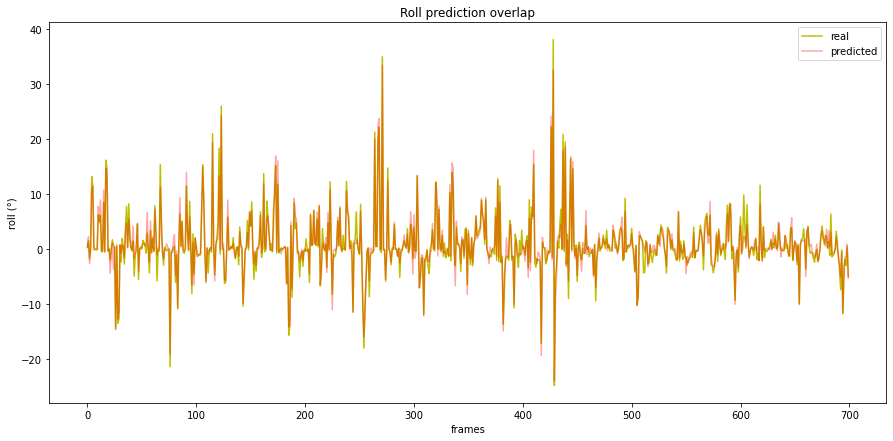

In [45]:
plt.figure(figsize=(15, 7))
plt.plot(denorm_labels[:700], label="real", color="y")
plt.plot(denorm_predictions[:700], label="predicted",color="r", alpha=0.35)
plt.xlabel('frames')
plt.ylabel('roll (°)')
plt.title("Roll prediction overlap")
plt.savefig(f'{RESULT_FOLDER}/roll_overlap_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.legend()

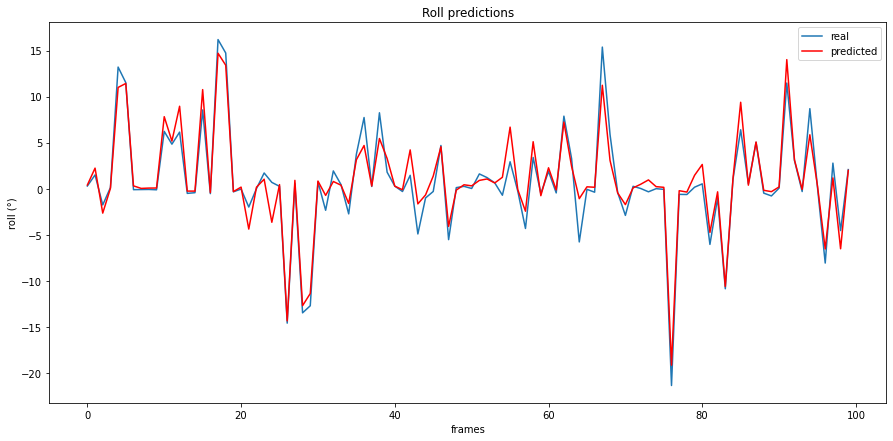

In [47]:
plt.figure(figsize=(15, 7))
plt.plot(denorm_labels[:100], label="real")
plt.plot(denorm_predictions[:100], label="predicted", color="r")
plt.xlabel('frames')
plt.ylabel('roll (°)')
plt.title("Roll predictions")
plt.savefig(f'{RESULT_FOLDER}/roll_prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.legend()

In [44]:
n = len(predictions)
loss = 0
loss0 = 0

for i in range(n):
    loss += (labels[i]-predictions[i])**2
    loss0 += (labels[i]-0)**2

mse = loss/n
rmse = math.sqrt(loss/n)
mse0 = loss0/n
rmse0 = math.sqrt(loss0/n)

print("Roll prediction")
print("   MSE:", round(mse, 5))
print("   RMSE:", round(rmse, 3))
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", round(mse0, 5))
print("   RMSE 0:", round(rmse0, 3))
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Roll prediction
   MSE: 0.00063
   RMSE: 0.025
   RMSE denorm: 2.25°
Zero prediction
   MSE 0: 0.00619
   RMSE 0: 0.079
   RMSE denorm: 7.08°
Improvement on zero prediction:
   MSE delta%: 986.35 %
   RMSE delta%: 314.06 %
